In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import sys

dir_path = os.path.abspath('')
sys.path.append(dir_path + '/../')

from interpolazione import Interpolazione, final_val

dir_path = os.path.abspath('')
FILE = dir_path + '/data/' + 'RC.csv'
fr = pd.read_csv(FILE)

V = np.array(fr['V (V)'])
t = np.array(fr['t (us)']) * 10**-6
R = 996 # ohm
sigmaR = R*0.01 # incertezza associata al multimetro
T = 2* (10**-3) # 2ms impostato dall'oscilloscopio TODO: verificare se vale la pena 
sigmaV = 0.08 / np.sqrt(12)#  0.08 / np.sqrt(12) # uniform distribution
# Vg = 4.95 # V

$
V_r(t) = \frac{2V_g}{{1 + e^{-\frac{T}{2\tau}}}}e^{-\frac{t}{\tau}} 
$

se T >> $\tau$ $\quad \Rightarrow \quad V_r(t) = 2V_ge^{-\frac{t}{\tau}} $ 

where $\tau = R \cdot C$

In [2]:
def VR(t, τ, Vg):
    return 2*Vg*np.exp(-t/τ) # /(1+np.exp(-T/(2*τ)))

In [3]:
C_guess = 99 * 10**-9 # 0.1 nF
Vg_guess = 4.95
i = Interpolazione(t,V,VR, sigmaV, p0=[R*C_guess, Vg_guess])
print(i)

print('----------------------- RESULT -----------------------')
# estrazione dei valori di C e Vg
Vg = i.bval[1]
sigmaVg = i.sigma_bval[1]
τ = i.bval[0]
sigmaτ = i.sigma_bval[0]

C = τ / R
sigmaC = np.sqrt((sigmaτ / R)**2 + (τ * sigmaR / R**2)**2)

print('C = ',final_val(C, sigmaC,exp=-9,decimals=1,udm='F')) # TODO: verificare quanti decimali siano necessari e controllare propagazione errori
print('Vg = ',final_val(Vg, sigmaVg,decimals=2,udm='V'))

   
Parameters: [1.04232457e-04 4.69998656e+00] 
Sigma parameters: [2.78747074e-07 8.35186035e-03]

sigmaY: 0.023094010767585032

chiquadro ridotto: 1.45
df: 40
pvalue: 100.0%
covariance matrix: [[ 7.04761282e-14 -1.53222449e-09]
 [-1.53222449e-09  6.32685454e-05]]    

----------------------- RESULT -----------------------
C =  (104.7 ± 1.1)e-9 F
Vg =  4.7 ± 0.01 V


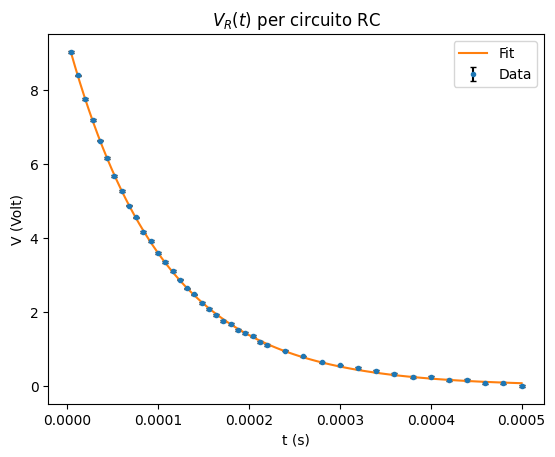

In [4]:
plt.errorbar(t, V, yerr=sigmaV, fmt='.',ecolor='black',label='Data',capsize=2)
plt.plot(i.x_best,i.y_best,label='Fit')

plt.xlabel('t (s)')
plt.ylabel('V (Volt)')
plt.title('$V_R(t)$ per circuito RC')
plt.legend()
plt.show()

$
V_c(t) = V_g - V_r
$

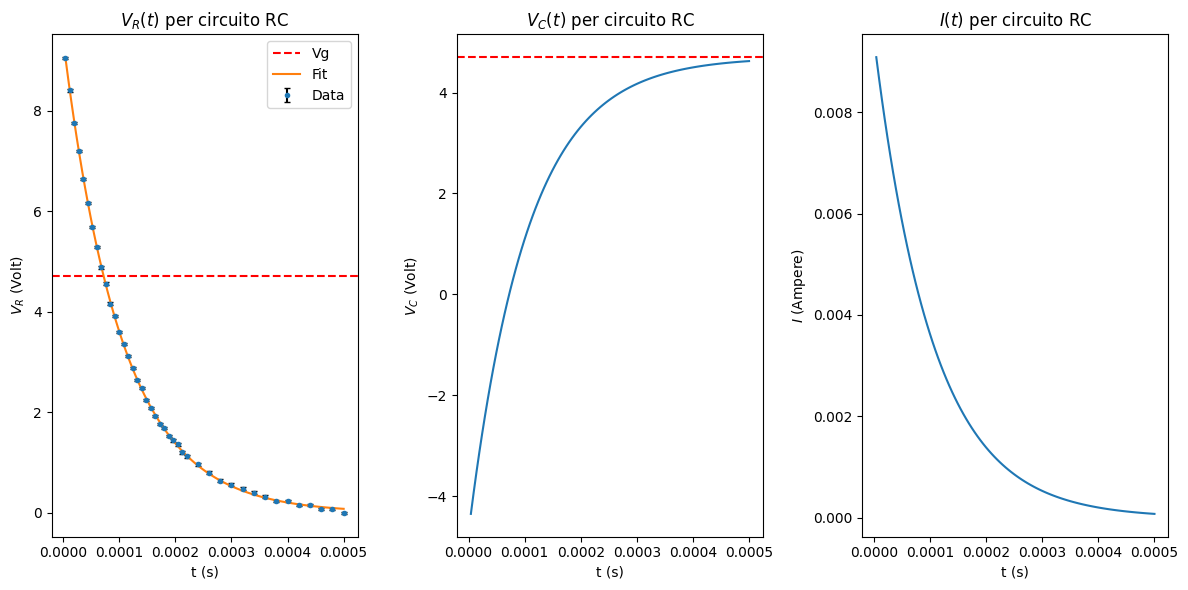

In [5]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(12, 6))
# Plot on the left
ax1.axhline(y=Vg, color='r', linestyle='--', label='Vg')
ax1.errorbar(t, V, yerr=sigmaV, fmt='.', ecolor='black', label='Data', capsize=2)
ax1.plot(i.x_best, i.y_best, label='Fit')
ax1.set_xlabel('t (s)')
ax1.set_ylabel('$V_R$ (Volt)')
ax1.set_title('$V_R(t)$ per circuito RC')
ax1.legend()

# Plot on the right
V_c = Vg - i.y_best
ax2.axhline(y=Vg, color='r', linestyle='--', label='Vg')
ax2.plot(i.x_best, V_c)
ax2.set_xlabel('t (s)')
ax2.set_ylabel('$V_C$ (Volt)')
ax2.set_title('$V_C(t)$ per circuito RC')

# Plot on the third
I = i.y_best / R
ax3.plot(i.x_best, I)
ax3.set_xlabel('t (s)')
ax3.set_ylabel('$I$ (Ampere)')
ax3.set_title('$I(t)$ per circuito RC')

plt.tight_layout()
plt.show()

# DOMANDE:

2. Noto il valore della resistenza R si può determinare con questo metodo il valore della
capacità C, con quale precisione? Quali sono i fattori che influenzano la precisione
della misura? La scelta del valore della resistenza R utilizzata per eseguire la misura
è rilevante ai fini della precisione della misura stessa?

Il fit determina $\tau$, dalla relazione $\tau = RC$ si può determinare C, la cui incertezza è legata a $\sigma_\tau$ e $\sigma_R$. La scelta di R influenza la stima della capacità perchè deve mantenersi valida la relazione RC << T

3. Sapreste “inventare” un metodo veloce per la misura della costante caratteristica
del circuito senza dover ricorrere al campionamento e ﬁt dei punti della curva di
carica/scarica?

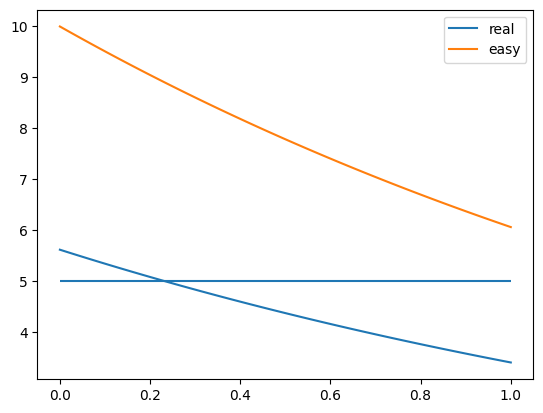

In [6]:
def VReal(t, τ, Vg):
    return 2*Vg*np.exp(-t/τ)/(1+np.exp(-T/(2*τ)))

def VR(t, τ, Vg):
    return 2*Vg*np.exp(-t/τ) # /(1+np.exp(-T/(2*τ)))

T = 1
τ = 2
Vg = 5
t = np.linspace(0,T,100)
Vreal = VReal(t,τ,Vg)
Veasy = VR(t,τ,Vg)
plt.plot(t,Vreal,label='real')
plt.plot(t,Veasy,label='easy')
plt.hlines(Vg,0,T)
plt.legend()
plt.show()